<a href="https://colab.research.google.com/github/mrmaggoo1/MAE-494/blob/main/HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[1.9584178 1.6891868]
0.00071549066
P_Optimised 1  = 28.824099527405245
P_measured 1  = 28.1
Error  P 1 value = -0.7240995274052437
P_Optimised 2  = 34.64431172371921
P_measured 2  = 34.4
Error  P 2 value = -0.24431172371921406
P_Optimised 3  = 36.45296597609965
P_measured 3  = 36.7
Error  P 3 value = 0.24703402390035478
P_Optimised 4  = 36.86731324695646
P_measured 4  = 36.9
Error  P 4 value = 0.03268675304353508
P_Optimised 5  = 36.87400644103766
P_measured 5  = 36.8
Error  P 5 value = -0.07400644103766041
P_Optimised 6  = 36.74983464830966
P_measured 6  = 36.7
Error  P 6 value = -0.04983464830965545
P_Optimised 7  = 36.3904500350543
P_measured 7  = 36.5
Error  P 7 value = 0.10954996494569968
P_Optimised 8  = 35.38482355380221
P_measured 8  = 35.4
Error  P 8 value = 0.015176446197791904
P_Optimised 9  = 32.947786549186844
P_measured 9  = 32.9
Error  P 9 value = -0.04778654918684566
P_Optimised 10  = 27.730002092297866
P_measured 10  = 27.7
Error  P 10 value = -0.030002092297866767
P_

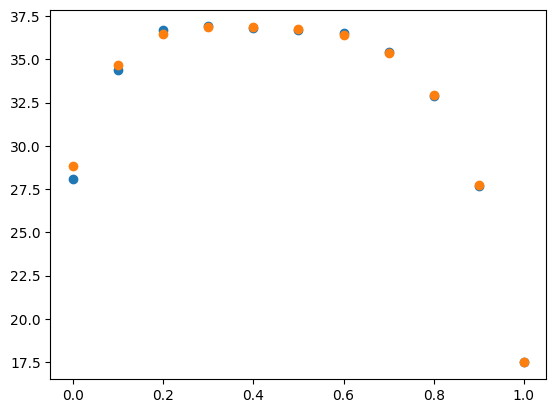

In [ ]:
# P1
from matplotlib import pyplot
import torch as t
from torch.autograd import Variable
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import math as m

x1=np.array([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
x2= 1 - (x1)
p_i=np.array([28.1,34.4,36.7,36.9,36.8,36.7,36.5,35.4,32.9,27.7,17.5])

T=20
aw1=8.07131
aw2=1730.63
aw3=233.426

ad1=7.43155
ad2=1554.679
ad3=240.337

lpw= aw1 - (aw2/(T+aw3))
Psat_water= 10 ** lpw

lpd= ad1 - (ad2/(T+ad3))
Psat_dioxane= 10 ** lpd

x = Variable(t.tensor([1.0, 1.0]), requires_grad=True)
s = 0.001


res = []

for i in range(100):
    for i in range(0,11):
        loss = (((x1[i]*t.exp(x[0]*((x[1]*x2[i])/(x[0]*x1[i]+x[1]*x2[i]))**2)*Psat_water) + (x2[i]*t.exp( x[1]*((x[0]*x1[i])/(x[0]*x1[i]+x[1]*x2[i]))**2)*Psat_dioxane)) - p_i[i])**2
        loss.backward()
    x.grad.numpy()
    with t.no_grad():
       x -= s * x.grad
       x.grad.zero_()
print(x.data.numpy())
print(loss.data.numpy())
for i in range(0,11):
  P_opt = ((x1[i]*m.exp(x[0]*((x[1]*x2[i])/(x[0]*x1[i]+x[1]*x2[i]))**2)*Psat_water) + (x2[i]*m.exp( x[1]*((x[0]*x1[i])/(x[0]*x1[i]+x[1]*x2[i]))**2)*Psat_dioxane))
  print("P_Optimised",i+1," =",P_opt)
  print("P_measured",i+1," =", p_i[i])
  print("Error  P",i+1,"value =" , p_i[i]-P_opt)
  res.append(P_opt)

#print (res)
pyplot.scatter(x1,p_i)
pyplot.scatter(x1,res)
pyplot.show()

In [10]:
# P2
## USING THE TUTORIAL CODE https://thuijskens.github.io/2016/12/29/bayesian-optimisation/

import numpy as np
import sklearn.gaussian_process as gp

from scipy.stats import norm
from scipy.optimize import minimize
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.datasets import make_classification

# EXPECTED IMPROVEMENT function.

def expected_improvement(x, gaussian_process, evaluated_loss, greater_is_better=False, n_params=1):

    x_to_predict = x.reshape(-1, n_params)

    mu, sigma = gaussian_process.predict(x_to_predict, return_std=True)

    if greater_is_better:
        loss_optimum = np.max(evaluated_loss)
    else:
        loss_optimum = np.min(evaluated_loss)

    scaling_factor = (-1) ** (not greater_is_better)

    # In case sigma equals zero
    with np.errstate(divide='ignore'):
        Z = scaling_factor * (mu - loss_optimum) / sigma
        expected_improvement = scaling_factor * (mu - loss_optimum) * norm.cdf(Z) + sigma * norm.pdf(Z)
        expected_improvement[sigma == 0.0] == 0.0

    return -1 * expected_improvement

# SAMPLE NEXT HYPERPARAMETER function.

def sample_next_hyperparameter(acquisition_func, gaussian_process, evaluated_loss, greater_is_better=False,
                               bounds=(0, 10), n_restarts=25):
    best_x = None
    best_acquisition_value = 1
    n_params = bounds.shape[0]

    for starting_point in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, n_params)):

        res = minimize(fun=acquisition_func,
                       x0=starting_point.reshape(1, -1),
                       bounds=bounds,
                       method='L-BFGS-B',
                       args=(gaussian_process, evaluated_loss, greater_is_better, n_params))

        if res.fun < best_acquisition_value:
            best_acquisition_value = res.fun
            best_x = res.x

    return best_x


#%% And then finally, the BAYESIAN OPTIMIZATION function.

def bayesian_optimisation(n_iters, sample_loss, bounds, x0=None, n_pre_samples=5,
                          gp_params=None, random_search=False, alpha=1e-5, epsilon=1e-7):

    x_list = []
    y_list = []

    n_params = bounds.shape[0]

    if x0 is None:
        for params in np.random.uniform(bounds[:, 0], bounds[:, 1], (n_pre_samples, bounds.shape[0])):
            x_list.append(params)
            y_list.append(sample_loss(params))
    else:
        for params in x0:
            x_list.append(params)
            y_list.append(sample_loss(params))

    xp = np.array(x_list)
    yp = np.array(y_list)

    # Create the GP
    if gp_params is not None:
        model = gp.GaussianProcessRegressor(**gp_params)
    else:
        kernel = gp.kernels.Matern()
        model = gp.GaussianProcessRegressor(kernel=kernel,
                                            alpha=alpha,
                                            n_restarts_optimizer=10,
                                            normalize_y=True)

    for n in range(n_iters):

        model.fit(xp, yp)

        # Sample next hyperparameter
        if random_search:
            x_random = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(random_search, n_params))
            ei = -1 * expected_improvement(x_random, model, yp, greater_is_better=True, n_params=n_params)
            next_sample = x_random[np.argmax(ei), :]
        else:
            next_sample = sample_next_hyperparameter(expected_improvement, model, yp, greater_is_better=True, bounds=bounds, n_restarts=100)

        # Duplicates will break the GP. In case of a duplicate, we will randomly sample a next query point.
        if np.any(np.abs(next_sample - xp) <= epsilon):
            next_sample = np.random.uniform(bounds[:, 0], bounds[:, 1], bounds.shape[0])

        # Sample loss for new set of parameters
        cv_score = sample_loss(next_sample)

        # Update lists
        x_list.append(next_sample)
        y_list.append(cv_score)

        # Update xp and yp
        xp = np.array(x_list)
        yp = np.array(y_list)

    return xp, yp

# Our loss function. AKA OBJECTIVE FUNCTION!!!!
def sample_loss(x): # takes in a vector [x1,x2]
    x1=x[0]
    x2=x[1]
    return -1*((4 - 2.1*x1**2 + (x1**4)/3)*x1**2 + x1*x2 + (-4 + 4*(x2**2))*x2**2)
# Start runnin...'
x_1 = np.linspace(-3,3)
x_2 = np.linspace(-2,2)

# We need the cartesian combination of these two vectors
param_grid = np.array([[x1i, x2i] for x1i in x_1 for x2i in x_2])

real_loss = [sample_loss(params) for params in param_grid]

# The maximum is at:
print('The true minimum value of ' + str(-np.amax(real_loss)) +' is at '+ str(param_grid[np.array(real_loss).argmax(), :]))
import warnings
warnings.filterwarnings('ignore')  # Let's ignore the warnings.

bounds = np.array([[-3, 3], [-2, 2]])

print('running Bayesian Opt.')

xp, yp = bayesian_optimisation(n_iters=100, # HERE WE GO!
                               sample_loss=sample_loss,
                               bounds=bounds,
                               n_pre_samples=3,
                               random_search=100000)

print('Out of 100 iterations, the minimum value of ' + str(-np.amax(yp)) +' is at ' + str(xp[np.where(yp == np.amax(yp))[0][0]]))


The true minimum value of -1.02614400718987 is at [-0.06122449  0.69387755]
running Bayesian Opt.
Out of 100 iterations, the minimum value of -1.0296330960524334 is at [-0.10531847  0.72492799]
